# 学習
- パラメータチューニング

In [1]:
# パラメータ設定

In [2]:
TARGET_DATE = '20210101'

In [3]:
# Parameters
TARGET_DATE = 20210101


In [4]:
TARGET_DATE = str(TARGET_DATE)

In [5]:
# ライブラリ読み込み

In [6]:
import pandas as pd
import numpy as np
import argparse
import shap
import optuna
import pickle
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [7]:
# dataframe設定調整

In [8]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [9]:
# データ読み込み

In [10]:
train = pd.read_pickle(f'../../data/trial/feature_{TARGET_DATE}.pkl')

In [11]:
target = 'TARGET'

In [12]:
X = train.drop(columns=target)

In [13]:
y = train[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=0,
                                                   stratify=y)

In [15]:
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    random_state=1,
                                                    stratify=y_train)

In [16]:
categorical_features = [
# 'prefecture_code'
]

In [17]:
lgb_train = lgb.Dataset(X_train, y_train,
                       categorical_feature=categorical_features,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_eval, y_eval, reference=lgb_train,
                       categorical_feature=categorical_features,
                       free_raw_data=False)

In [18]:
def objective(trial):

    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'n_jobs': -1,
        'boosting_type': 'gbdt',
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    evaluation_results = {}                                     # 学習の経過を保存する箱
    model = lgb.train(
        param,                                   # 上記で設定したパラメータ
        lgb_train,                                # 使用するデータセット
        num_boost_round=1000,                     # 学習の回数
        valid_names=['train', 'valid'],           # 学習経過で表示する名称
        valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
        evals_result=evaluation_results,          # 学習の経過を保存
        categorical_feature=categorical_features, # カテゴリー変数を設定
        early_stopping_rounds=50,                 # アーリーストッピング
        verbose_eval=10)                          # 学習の経過の表示(10回毎)
    
    y_pred = model.predict(X_train, num_iteration=model.best_iteration)
    
    # metrics AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
    score = metrics.auc(fpr, tpr)

    # metrics F1
#     score = f1_score(y_train, y_pred)

    # MLFlow
#     with mlflow.start_run() as run:
#         mlflow.log_params(param)
#         mlflow.log_metrics({'accuracy': accuracy})
#         mlflow.lightgbm.log_model(gbm, 'model', args.conda_env)
#     print('Model logged in run {}'.format(run.info.run_uuid))
    return score

In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print('Number of finished trials: {}'.format(len(study.trials)))

print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))

print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2021-01-22 10:43:31,892]

 A new study created in memory with name: no-name-153ee88f-06a9-497a-85eb-98263d77875e

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.778	valid's auc: 0.726713

[20]	train's auc: 0.81471	valid's auc: 0.733736

[30]	train's auc: 0.841701	valid's auc: 0.735061

[40]	train's auc: 0.86671	valid's auc: 0.73526

[50]	train's auc: 0.887907	valid's auc: 0.733756

[60]	train's auc: 0.903845	valid's auc: 0.733013

[70]	train's auc: 0.916608	valid's auc: 0.732047

[80]	train's auc: 0.928195	valid's auc: 0.730632

Early stopping, best iteration is:
[38]	train's auc: 0.861487	valid's auc: 0.736132

[I 2021-01-22 10:43:35,002]

 Trial 0 finished with value: 0.8614868157380461 and parameters: {'lambda_l1': 9.43487209670849e-06, 'lambda_l2': 6.000178070520167e-05, 'num_leaves': 222, 'feature_fraction': 0.8800404939995382, 'bagging_fraction': 0.616228130909344, 'bagging_freq': 5, 'min_child_samples': 22}. Best is trial 0 with value: 0.8614868157380461.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.760416	valid's auc: 0.73239

[20]	train's auc: 0.775714	valid's auc: 0.738456

[30]	train's auc: 0.790309	valid's auc: 0.741232

[40]	train's auc: 0.803071	valid's auc: 0.743329

[50]	train's auc: 0.814178	valid's auc: 0.745459

[60]	train's auc: 0.824614	valid's auc: 0.745625

[70]	train's auc: 0.834533	valid's auc: 0.744834

[80]	train's auc: 0.843156	valid's auc: 0.744714

[90]	train's auc: 0.851364	valid's auc: 0.745039

[100]	train's auc: 0.860053	valid's auc: 0.744846

[110]	train's auc: 0.867885	valid's auc: 0.744088

Early stopping, best iteration is:
[64]	train's auc: 0.828762	valid's auc: 0.745806

[I 2021-01-22 10:43:39,126]

 Trial 1 finished with value: 0.8287619102078271 and parameters: {'lambda_l1': 2.7848272905911187, 'lambda_l2': 7.66563100449721e-08, 'num_leaves': 107, 'feature_fraction': 0.8226131657906224, 'bagging_fraction': 0.6868246293041356, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 0 with value: 0.8614868157380461.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.761966	valid's auc: 0.722613

[20]	train's auc: 0.785783	valid's auc: 0.737114

[30]	train's auc: 0.800005	valid's auc: 0.739266

[40]	train's auc: 0.813634	valid's auc: 0.739724

[50]	train's auc: 0.826454	valid's auc: 0.739906

[60]	train's auc: 0.839135	valid's auc: 0.74034

[70]	train's auc: 0.851391	valid's auc: 0.740268

[80]	train's auc: 0.862472	valid's auc: 0.738658

[90]	train's auc: 0.872275	valid's auc: 0.738585

[100]	train's auc: 0.879882	valid's auc: 0.738753

Early stopping, best iteration is:
[56]	train's auc: 0.834349	valid's auc: 0.74075

[I 2021-01-22 10:43:42,412]

 Trial 2 finished with value: 0.834349418286175 and parameters: {'lambda_l1': 0.10458515051038095, 'lambda_l2': 0.0015541471168766135, 'num_leaves': 124, 'feature_fraction': 0.4157225849070554, 'bagging_fraction': 0.5334320206088372, 'bagging_freq': 2, 'min_child_samples': 21}. Best is trial 0 with value: 0.8614868157380461.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.783633	valid's auc: 0.731699

[20]	train's auc: 0.818048	valid's auc: 0.73408

[30]	train's auc: 0.849217	valid's auc: 0.736393

[40]	train's auc: 0.874916	valid's auc: 0.737897

[50]	train's auc: 0.894774	valid's auc: 0.738786

[60]	train's auc: 0.912496	valid's auc: 0.737092

[70]	train's auc: 0.927045	valid's auc: 0.736119

[80]	train's auc: 0.938321	valid's auc: 0.736159

[90]	train's auc: 0.947259	valid's auc: 0.734679

Early stopping, best iteration is:
[47]	train's auc: 0.888917	valid's auc: 0.739159

[I 2021-01-22 10:43:45,534]

 Trial 3 finished with value: 0.8889169817441438 and parameters: {'lambda_l1': 2.2423051871000533e-08, 'lambda_l2': 1.199991370624013e-08, 'num_leaves': 225, 'feature_fraction': 0.9755560308198515, 'bagging_fraction': 0.8379964913895002, 'bagging_freq': 3, 'min_child_samples': 26}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.790362	valid's auc: 0.728865

[20]	train's auc: 0.812358	valid's auc: 0.738172

[30]	train's auc: 0.830355	valid's auc: 0.739905

[40]	train's auc: 0.847957	valid's auc: 0.740725

[50]	train's auc: 0.86539	valid's auc: 0.740614

[60]	train's auc: 0.880607	valid's auc: 0.739981

[70]	train's auc: 0.894587	valid's auc: 0.738763

[80]	train's auc: 0.907816	valid's auc: 0.7371

[90]	train's auc: 0.919121	valid's auc: 0.736358

Early stopping, best iteration is:
[45]	train's auc: 0.855863	valid's auc: 0.741144

[I 2021-01-22 10:43:48,299]

 Trial 4 finished with value: 0.8558629905494132 and parameters: {'lambda_l1': 2.144819178673477e-07, 'lambda_l2': 3.4626769156456904e-06, 'num_leaves': 213, 'feature_fraction': 0.44749453479534995, 'bagging_fraction': 0.8122183471790609, 'bagging_freq': 2, 'min_child_samples': 67}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.785509	valid's auc: 0.727503

[20]	train's auc: 0.807899	valid's auc: 0.737101

[30]	train's auc: 0.826339	valid's auc: 0.736649

[40]	train's auc: 0.843095	valid's auc: 0.73787

[50]	train's auc: 0.859252	valid's auc: 0.737416

[60]	train's auc: 0.874483	valid's auc: 0.736958

[70]	train's auc: 0.888309	valid's auc: 0.734898

[80]	train's auc: 0.900294	valid's auc: 0.734006

Early stopping, best iteration is:
[39]	train's auc: 0.841648	valid's auc: 0.737988

[I 2021-01-22 10:43:50,952]

 Trial 5 finished with value: 0.8416484138102974 and parameters: {'lambda_l1': 0.005067755953270618, 'lambda_l2': 2.1330788043240945e-07, 'num_leaves': 216, 'feature_fraction': 0.5362084388183074, 'bagging_fraction': 0.6289109176169222, 'bagging_freq': 7, 'min_child_samples': 83}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.751809	valid's auc: 0.737602

[20]	train's auc: 0.759618	valid's auc: 0.741359

[30]	train's auc: 0.766253	valid's auc: 0.744125

[40]	train's auc: 0.771604	valid's auc: 0.746517

[50]	train's auc: 0.776668	valid's auc: 0.747921

[60]	train's auc: 0.78156	valid's auc: 0.748612

[70]	train's auc: 0.786264	valid's auc: 0.74922

[80]	train's auc: 0.790389	valid's auc: 0.749054

[90]	train's auc: 0.79449	valid's auc: 0.748681

[100]	train's auc: 0.798257	valid's auc: 0.748763

[110]	train's auc: 0.802587	valid's auc: 0.748484

[120]	train's auc: 0.806079	valid's auc: 0.748338

Early stopping, best iteration is:
[71]	train's auc: 0.78669	valid's auc: 0.749259

[I 2021-01-22 10:43:53,634]

 Trial 6 finished with value: 0.7866901317820292 and parameters: {'lambda_l1': 0.570131278388283, 'lambda_l2': 8.855244968363186, 'num_leaves': 49, 'feature_fraction': 0.6143878805678117, 'bagging_fraction': 0.5014825996516898, 'bagging_freq': 3, 'min_child_samples': 78}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.754385	valid's auc: 0.73262

[20]	train's auc: 0.771081	valid's auc: 0.739542

[30]	train's auc: 0.784653	valid's auc: 0.742549

[40]	train's auc: 0.796423	valid's auc: 0.745479

[50]	train's auc: 0.808714	valid's auc: 0.746744

[60]	train's auc: 0.818577	valid's auc: 0.747268

[70]	train's auc: 0.826687	valid's auc: 0.747461

[80]	train's auc: 0.836033	valid's auc: 0.74701

[90]	train's auc: 0.844188	valid's auc: 0.746418

[100]	train's auc: 0.851448	valid's auc: 0.745989

[110]	train's auc: 0.858668	valid's auc: 0.744652

[120]	train's auc: 0.864999	valid's auc: 0.743361

Early stopping, best iteration is:
[70]	train's auc: 0.826687	valid's auc: 0.747461

[I 2021-01-22 10:43:57,133]

 Trial 7 finished with value: 0.8266868584899157 and parameters: {'lambda_l1': 2.2845759890917718e-07, 'lambda_l2': 8.041311839869345e-05, 'num_leaves': 79, 'feature_fraction': 0.876192006092221, 'bagging_fraction': 0.8002730709906866, 'bagging_freq': 6, 'min_child_samples': 59}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.787425	valid's auc: 0.73059

[20]	train's auc: 0.820848	valid's auc: 0.735254

[30]	train's auc: 0.851143	valid's auc: 0.739526

[40]	train's auc: 0.87449	valid's auc: 0.740374

[50]	train's auc: 0.895228	valid's auc: 0.739363

[60]	train's auc: 0.911251	valid's auc: 0.738873

[70]	train's auc: 0.925763	valid's auc: 0.738733

[80]	train's auc: 0.937199	valid's auc: 0.737782

Early stopping, best iteration is:
[38]	train's auc: 0.870035	valid's auc: 0.740666

[I 2021-01-22 10:44:00,171]

 Trial 8 finished with value: 0.870034999937479 and parameters: {'lambda_l1': 0.0009973078407038301, 'lambda_l2': 5.9240436677089076e-05, 'num_leaves': 238, 'feature_fraction': 0.975164844699961, 'bagging_fraction': 0.9493035632893598, 'bagging_freq': 5, 'min_child_samples': 46}. Best is trial 3 with value: 0.8889169817441438.

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.749537	valid's auc: 0.73452

[20]	train's auc: 0.759243	valid's auc: 0.739629

[30]	train's auc: 0.767362	valid's auc: 0.742225

[40]	train's auc: 0.773339	valid's auc: 0.744004

[50]	train's auc: 0.78054	valid's auc: 0.746781

[60]	train's auc: 0.78647	valid's auc: 0.7475

[70]	train's auc: 0.792275	valid's auc: 0.747255

[80]	train's auc: 0.797408	valid's auc: 0.747792

[90]	train's auc: 0.802483	valid's auc: 0.746876

[100]	train's auc: 0.807526	valid's auc: 0.746951

[110]	train's auc: 0.811611	valid's auc: 0.746861

[120]	train's auc: 0.815888	valid's auc: 0.746537

[130]	train's auc: 0.820183	valid's auc: 0.746361

Early stopping, best iteration is:
[80]	train's auc: 0.797408	valid's auc: 0.747792

[I 2021-01-22 10:44:02,811]

 Trial 9 finished with value: 0.7974078534447853 and parameters: {'lambda_l1': 0.06912522986513929, 'lambda_l2': 2.932989530448621e-07, 'num_leaves': 43, 'feature_fraction': 0.6375747821408966, 'bagging_fraction': 0.5948981966253097, 'bagging_freq': 7, 'min_child_samples': 55}. Best is trial 3 with value: 0.8889169817441438.

Number of finished trials: 10

Best trial:

  Value: 0.8889169817441438

  Params: 

    lambda_l1: 2.2423051871000533e-08

    lambda_l2: 1.199991370624013e-08

    num_leaves: 225

    feature_fraction: 0.9755560308198515

    bagging_fraction: 0.8379964913895002

    bagging_freq: 3

    min_child_samples: 26

In [20]:
# 二値分類
params = {
            'boosting_type': 'gbdt',        # 勾配ブースティング
            'objective': 'binary',      # 目的関数：多値分類、マルチクラス分類
            'metric': 'auc',      # 分類モデルの性能を測る指標
         }

In [21]:
params = dict(params, **study.best_params)

In [22]:
evaluation_results = {}                                     # 学習の経過を保存する箱
model = lgb.train(params,                                   # 上記で設定したパラメータ
                  lgb_train,                                # 使用するデータセット
                  num_boost_round=1000,                     # 学習の回数
                  valid_names=['train', 'valid'],           # 学習経過で表示する名称
                  valid_sets=[lgb_train, lgb_eval],         # モデル検証のデータセット
                  evals_result=evaluation_results,          # 学習の経過を保存
                  categorical_feature=categorical_features, # カテゴリー変数を設定
                  early_stopping_rounds=50,                 # アーリーストッピング
                  verbose_eval=10)                          # 学習の経過の表示(10回毎)

# 最もスコアが良いときのラウンドを保存
optimum_boost_rounds = model.best_iteration

[LightGBM] [Warning] 

Find whitespaces in feature_names, replace with underlines

[LightGBM] [Info] 

Number of positive: 15390, number of negative: 175016

[LightGBM] [Warning] 

Auto-choosing row-wise multi-threading, the overhead of testing was 0.008625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

[LightGBM] [Info] 

Total Bins 3201

[LightGBM] [Info] 

Number of data points in the train set: 190406, number of used features: 26

[LightGBM] [Info] 

[binary:BoostFromScore]: pavg=0.080827 -> initscore=-2.431159

[LightGBM] [Info] 

Start training from score -2.431159

Training until validation scores don't improve for 50 rounds

[10]	train's auc: 0.783633	valid's auc: 0.731699

[20]	train's auc: 0.818048	valid's auc: 0.73408

[30]	train's auc: 0.849217	valid's auc: 0.736393

[40]	train's auc: 0.874916	valid's auc: 0.737897

[50]	train's auc: 0.894774	valid's auc: 0.738786

[60]	train's auc: 0.912496	valid's auc: 0.737092

[70]	train's auc: 0.927045	valid's auc: 0.736119

[80]	train's auc: 0.938321	valid's auc: 0.736159

[90]	train's auc: 0.947259	valid's auc: 0.734679

Early stopping, best iteration is:
[47]	train's auc: 0.888917	valid's auc: 0.739159

0.8889169817441438

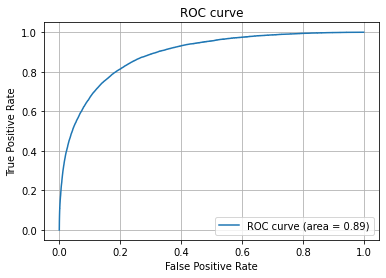

In [23]:
# # 訓練データで予測
y_pred = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

0.7490288907552372

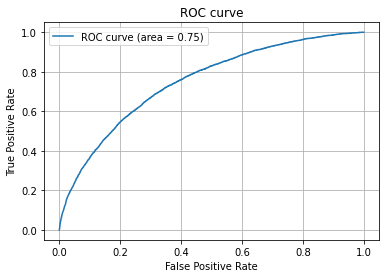

In [24]:
# # テストデータで予測
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.round(y_pred)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(fpr, tpr)
print(auc)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

In [25]:
pickle.dump(model, open(f'../../data/trial/model_{TARGET_DATE}.pkl', 'wb'))